In [1]:
import io
import itertools 
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime

In [3]:
#preprocessing Mnist Dataset 

Buffer_Size = 70_000
Batch_Size = 128
Epochs = 20

In [4]:
mnist_dataset , mnist_info = tfds.load(name = 'mnist' , with_info = True, as_supervised = True)

In [5]:
mnist_train , mnist_test = mnist_dataset['train'] , mnist_dataset['test']

In [6]:
def scale ( image, label) :
    image = tf.cast(image, tf.float32)
    image /=255.
    return image, label

In [7]:
train_valid_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [8]:
num_valid_samples= 0.1 * mnist_info.splits['train'].num_examples
num_valid_samples= tf.cast(num_valid_samples , tf.int64)

In [9]:
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [10]:
num_test_samples

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [11]:
num_valid_samples

<tf.Tensor: shape=(), dtype=int64, numpy=6000>

In [12]:
train_valid_data = train_valid_data.shuffle(Buffer_Size)

In [13]:
train_data = train_valid_data.skip(num_valid_samples)
validation_data = train_valid_data.take(num_valid_samples)

In [14]:
train_data = train_data.batch(Batch_Size)
validation_data = validation_data.batch(num_valid_samples)
test_data = test_data.batch(num_test_samples)

In [15]:
for images , labels in validation_data:
    images_val = images.numpy()
    labels_val = labels.numpy()

In [17]:
#Creating the Model and Training it 
model = tf.keras.Sequential( [
    tf.keras.layers.Conv2D(50, 5, activation = 'relu' , input_shape = (28,28,1)) ,
    tf.keras.layers.MaxPooling2D ( pool_size = (2,2)) ,
    tf.keras.layers.Conv2D(50 , 3, activation = 'relu') ,
    tf.keras.layers.MaxPooling2D ( pool_size =(2,2)) ,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

In [18]:
model.summary(line_length = 75 )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)              │ (None, 24, 24, 50)      │        1,300 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_2 (MaxPooling2D) │ (None, 12, 12, 50)      │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv2d_3 (Conv2D)              │ (None, 10, 10, 50)      │       22,550 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_3 (MaxPooling2D) │ (None, 5, 5, 50)        │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten_1 (Flatten)            │ (None, 1250)            │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense_1 (Dense)                │ (None, 10)              │       12,510 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 36,360 (142.03 KB)

 Trainable params: 36,360 (142.03 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [20]:
model.compile(optimizer = 'adam', loss = loss_function, metrics= ['accuracy'])

In [37]:
#A folder where we are going to save the log files name + datetime 

log_dir = "log\\fit\\" + "run-1"

In [38]:
#Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [39]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [40]:
# Define a file writer variable for logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(images_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
    
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [41]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1 , profile_batch=0)

In [42]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)


In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping (
    monitor = 'val_loss' , 
    mode = 'auto' , 
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True
)

In [44]:
model.fit (
    train_data,
    epochs = Epochs,
    callbacks = [tensorboard_callback ,cm_callback ,early_stopping],
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 19ms/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9972 - val_loss: 0.0080
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
422/422 - 7s - 16ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0.9980 - val_loss: 0.0058
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 16ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9993 - val_loss: 0.0022
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 16ms/step - accuracy: 0.9987 - loss: 0.0041 - val_accuracy: 0.9972 - val_loss: 0.0080
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 16ms/step - accuracy: 0.9979 - loss: 0.0060 - val_accuracy: 0.9997 - val_loss: 0.0027


In [45]:
#Visualizing in Tensorboard
%load_ext tensorboard
%tensorboard --logdir "log/fit"


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10084), started 0:05:00 ago. (Use '!kill 10084' to kill it.)

In [46]:
#Testing Our Model

test_loss , test_accuracy = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9919 - loss: 0.0377


In [47]:
#Plotting Images and The results 

import matplotlib.pyplot as plt
import numpy as np

In [48]:
#split the test data into 2 arrays, containing the images and the corresponding labels ( output )

for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

In [49]:
#Reshape the images into 28*28 form, suitable for matplotlib (original dim = 28*28*1)

images_plot = np.reshape(images_test, (10000, 28 , 28))

Label : 4 


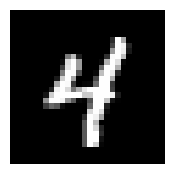

In [50]:
#in "i" , we are going to put a index of an image from 1 to 10000 for testing 
i = 545

#plot the image and see the label (result) 
plt.figure( figsize = (2,2))
plt.axis('off')
plt.imshow(images_plot[i-1] , cmap = 'gray' , aspect = 'auto')

#print the correct label for this image 
print("Label : {} ".format(labels_test[i-1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<BarContainer object of 10 artists>

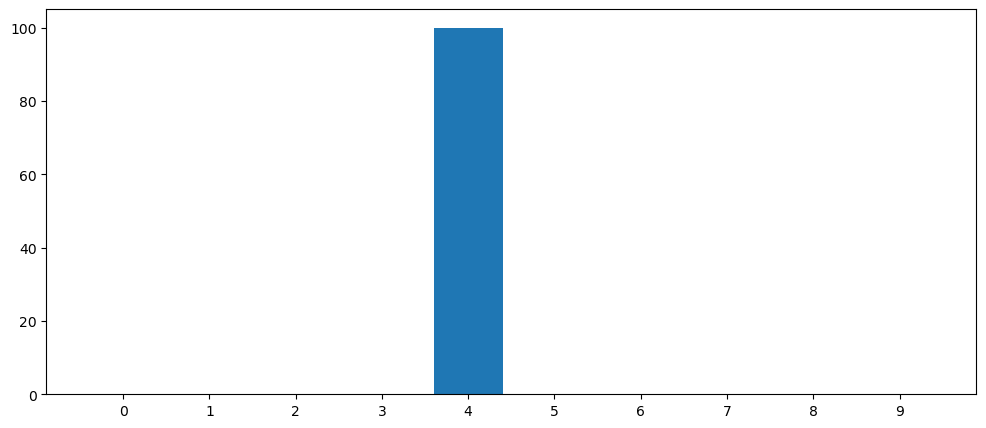

In [51]:
#Let's predict 

predictions = model.predict(images_test[i-1:i])

proba = tf.nn.softmax(predictions).numpy()

proba = proba*100


plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10] , height = proba[0] , tick_label=["0","1","2","3","4","5","6","7","8","9"])